I'm giving a talk about my 2DHOD AB models and their use in inferring cosmology. I need to make a few plots for that, and I'd like to do it all in one place. 

I need to make:
 * Cen-sat HOD plot x
 * Split decorated HOD plot x
 * Decorated HOD step func plot
 * “” for Yao model, cont model
 * SHAM ratio(s) plot
 * Tabulated HOD plot


In [1]:
import numpy as np
from pearce.mocks.kittens import TrainingBox, Chinchilla
from scipy.stats import binned_statistic, binned_statistic_2d

In [2]:
from halotools.utils.table_utils import compute_conditional_percentiles
from halotools.mock_observables import hod_from_mock, get_haloprop_of_galaxies

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [4]:
cat = TrainingBox(boxno=0)
cat.load(1.0, HOD='zheng07')

In [5]:
cat.model.param_dict['logMmin'] = 13.0
cat.model.param_dict['logM0'] = 12.5

In [6]:
print cat.model.param_dict

{'logM0': 12.5, 'sigma_logM': 0.26, 'logMmin': 13.0, 'alpha': 1.06, 'logM1': 13.31}


In [7]:
cat.populate(min_ptcl=50)

/u/ki/swmclau2/.local/lib/python2.7/site-packages/halotools-0.7.dev5005-py2.7-linux-x86_64.egg/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/u/ki/swmclau2/.local/lib/python2.7/site-packages/halotools-0.7.dev5005-py2.7-linux-x86_64.egg/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_in

In [8]:
mass_bin_range = (11,16)
mass_bin_size = 0.1
cen_hod = cat.calc_hod(mass_bin_range=mass_bin_range, mass_bin_size=mass_bin_size, component='central')
sat_hod = cat.calc_hod(mass_bin_range=mass_bin_range, mass_bin_size=mass_bin_size, component='satellite')

In [9]:
mass_bins = np.logspace(mass_bin_range[0], mass_bin_range[1],
                           int((mass_bin_range[1] - mass_bin_range[0]) / mass_bin_size) + 1)
mass_bin_centers = (mass_bins[:-1] + mass_bins[1:]) / 2

---

In [10]:
# TODO consistent plot language between each of these. Each model should have a corresponding color

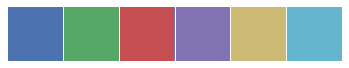

In [11]:
current_palette = sns.color_palette()
sns.palplot(current_palette)


In [12]:
model_color_map = {'HOD': (current_palette[0], "GnBu_d"),
                    'HSAB': (current_palette[1], "YlGn_d"),
                   'SHAM': (current_palette[2], "OrRd_d"),
                   'CAB': (current_palette[3], "RdPu_d"),
                   'CorrAB': (current_palette[4], "YlOrBr_d"),
                    'Halos': (current_palette[5], 'PuBu_d')} # add CMAPs too

In [13]:
def split_hod_plot(HOD, ab_params, n_splits = 4, cmap_name = 'blue'):
    cat.load_model(1.0, HOD=HOD)
    cat.model.param_dict['logMmin'] = 13.0
    cat.model.param_dict['logM0'] = 12.5
    
    cat.populate(ab_params, min_ptcl = 100)
    catalog = cat.model.mock.galaxy_table
    sec_percentiles = compute_conditional_percentiles(prim_haloprop = cat.model.mock.halo_table['halo_mvir'],\
                                                  sec_haloprop = cat.model.mock.halo_table['halo_nfw_conc'],
                                              prim_haloprop_bin_boundaries= mass_bins)
    
    sec_gal_percentiles = get_haloprop_of_galaxies(catalog['halo_id'], cat.model.mock.halo_table['halo_id'],
                                               sec_percentiles)
    
    # TODO bins here
    hods = np.zeros((n_splits, len(mass_bin_centers)))
    perc_ranges = np.linspace(0,1, n_splits+1)
    
    cmap = sns.color_palette(cmap_name, n_splits)
    #cmap = sns.dark_palette(cmap_name, n_splits)

    for i,c in enumerate(cmap):
        sec_bin_gals = np.logical_and(perc_ranges[i] < sec_gal_percentiles, sec_gal_percentiles<perc_ranges[i+1])
        sec_bin_halos = np.logical_and(perc_ranges[i] < sec_percentiles, sec_percentiles<perc_ranges[i+1])

        sec_gal_hist, _ = np.histogram(catalog[sec_bin_gals]['halo_mvir'], bins = mass_bins)
        sec_halo_hist, _= np.histogram(cat.model.mock.halo_table[sec_bin_halos]['halo_mvir'], bins = mass_bins)
        
        hods[i, :] = sec_gal_hist*1.0/sec_halo_hist
        plt.plot(mass_bin_centers, hods[i], c = c, label = 'p < %0.2f'%perc_ranges[i+1])

    
    gal_hist, _ = np.histogram(catalog['halo_mvir'], bins = mass_bins)
    halo_hist, _= np.histogram(cat.model.mock.halo_table['halo_mvir'], bins = mass_bins)
    full_hod = gal_hist*1.0/halo_hist
    
    
    plt.plot(mass_bin_centers, full_hod, label = 'Full HOD', color = 'k')
    plt.legend(loc='best')
    plt.loglog()
    plt.xlim(1e12,5e14)
    plt.ylim([0, 40])
    plt.xlabel(r"Host Halo Mass [$M_{\odot}$]")
    plt.ylabel(r"$\langle N_t | M \rangle$")
    plt.show()

---

In [14]:
def select_mass_bin(bin_no, arr, mass_arr, mass_bins=mass_bins):
    in_bin = np.logical_and(mass_bins[bin_no] < mass_arr, mass_arr < mass_bins[bin_no+1])
    return arr[in_bin]

In [15]:
def single_bin_cen_occ_plot(HOD, ab_params, bin_no, color = current_palette[1]):
    cat.load_model(1.0, HOD=HOD)
    cat.model.param_dict['logMmin'] = 13.0
    cat.model.param_dict['logM0'] = 12.5

    cat.populate(ab_params, min_ptcl = 100)
    
    mean_occ = cat.model._input_model_dictionary['centrals_occupation'].mean_occupation
    
    base_mean_occ = cat.model._input_model_dictionary['centrals_occupation'].baseline_mean_occupation
    baseline_result = base_mean_occ(prim_haloprop = cat.model.mock.halo_table['halo_mvir'])
    
    pert_result = mean_occ(prim_haloprop = cat.model.mock.halo_table['halo_mvir'],\
                           sec_haloprop = cat.model.mock.halo_table['halo_nfw_conc'])
    
    pert_in_bin = select_mass_bin(bin_no, pert_result, cat.model.mock.halo_table['halo_mvir'])
    baseline_in_bin = select_mass_bin(bin_no, baseline_result, cat.model.mock.halo_table['halo_mvir'])
    sec_in_bin = select_mass_bin(bin_no, cat.model.mock.halo_table['halo_nfw_conc'], cat.model.mock.halo_table['halo_mvir'])
    
    sec_sort_idx = np.argsort(sec_in_bin)
    baseline_in_bin_avg = binned_statistic(np.linspace(0, 1, len(sec_sort_idx)),
                                       baseline_in_bin[sec_sort_idx], bins = 100)[0]
    pert_in_bin_avg = binned_statistic(np.linspace(0, 1, len(sec_sort_idx)),
                                       pert_in_bin[sec_sort_idx], bins = 100)[0]

    # TODO compute mean in bins of conc perc
    plt.plot(np.linspace(0,1,100), baseline_in_bin_avg, c = model_color_map['HOD'][0])
    plt.plot(np.linspace(0,1,100), pert_in_bin_avg, c=color)
    
    plt.ylim([-0.2,1.2])

    plt.title(r'$\log_{10}M = $ %0.1f'%np.log10(mass_bin_centers[bin_no]))
    plt.xlabel('Secondary Halo Propety Percentile')
    plt.ylabel(r'$\langle N_{cen} | M \rangle$')
    plt.show()

In [16]:
bin_no = 20

---

In [17]:
from AbundanceMatching import *
from halotools.mock_observables import tpcf
from halotools.sim_manager import RockstarHlistReader

In [18]:
#sham clusterings computed on ds14b
rbins = np.logspace(-1.1, 1.6, 19)
rbc = (rbins[1:]+rbins[:-1])/2.0

In [19]:
cat2 = Chinchilla(400, 2048)

cat2.load_catalog(1.0)
halocat = cat2.halocat.halo_table

In [20]:
def make_sham(halocat, ab_property, nd=1e-3):
    #smf = np.genfromtxt('smf_dr72bright34_m7_lowm.dat', skip_header=True)[:,0:2]
    #af = AbundanceFunction(smf[:,0], smf[:,1], (9.0, 12.9), faint_end_first = True)
    lf = np.genfromtxt('/u/ki/swmclau2/des/AB_tests/lf_r_sersic_r.dat', skip_header=True)
    af = AbundanceFunction(lf[:,1], lf[:,2],(-26, -12), )
    
    scatter = 0.2
    remainder = af.deconvolute(scatter, 20)

    nd_halos = calc_number_densities(halocat[ab_property], cat2.Lbox) #don't think this matters which one i choose here

    catalog = af.match(nd_halos, scatter)

    n_obj_needed = int(nd*(cat2.Lbox**3))

    non_nan_idxs = ~np.isnan(catalog)
    sort_idxs = np.argsort(catalog[non_nan_idxs])#[::-1]
    final_catalog = catalog[non_nan_idxs][sort_idxs[:n_obj_needed]]
    output = halocat[non_nan_idxs][sort_idxs[:n_obj_needed]]
    output['gal_smass'] = final_catalog

    return output

In [21]:
galcat = make_sham(halocat, 'halo_vpeak')

In [22]:
gal_pos = np.vstack(np.array(galcat['halo_%s'%coord]) for coord in ['x', 'y', 'z']).T/cat2.h

/afs/slac.stanford.edu/u/ki/swmclau2/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':


In [23]:
sham_xi = tpcf(gal_pos, rbins, do_cross = False, estimator = 'Landy-Szalay', num_threads = 4, period = cat2.Lbox/cat2.h)

In [24]:
cen_mask = galcat['halo_upid'] == -1
sham_cen_hod = hod_from_mock(galcat[cen_mask]['halo_mvir_host_halo'], halocat['halo_mvir'], mass_bins)[0]
sham_sat_hod = hod_from_mock(galcat[~cen_mask]['halo_mvir_host_halo'], halocat['halo_mvir'], mass_bins)[0]

In [25]:
from pearce.mocks.customHODModels import TabulatedCens, TabulatedSats, HSAssembiasTabulatedCens, HSAssembiasTabulatedSats
from pearce.mocks.customHODModels import AssembiasTabulatedCens, AssembiasTabulatedSats, CorrAssembiasTabulatedCens, CorrAssembiasTabulatedSats

In [26]:
#sham_sat_hod[sham_sat_hod< 1e-2] = 0.0

In [27]:
def tabulated_hod_xi(sham_hod, hod_model, ab_dict = {}):
    sham_cen_hod, sham_sat_hod = sham_hod
    cat2.load_model(1.0, HOD=hod_model, hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
                                                               #'sec_haloprop_key': 'halo_%s'%(mag_type),
                                                               'cen_hod_vals':sham_cen_hod,
                                                               'sat_hod_vals':sham_sat_hod} )
    
    cat2.model.param_dict.update(ab_dict)
    out = np.zeros((10, rbins.shape[0]-1,))
    for i in xrange(10):
        cat2.populate(min_ptcl=100)
        out[i] = cat2.calc_xi(rbins)
        
    return out.mean(axis = 0)

---

In [28]:
def occ_jointplot(catalog, bin_no, mass_bins, params = ('halo_vpeak', 'halo_nfw_conc' ), param_bounds = None , color = current_palette[0]):
    
    fig = plt.figure(figsize = (10,10))
    
    mass_cut = np.logical_and(mass_bins[bin_no]< catalog['halo_mvir'], catalog['halo_mvir']<mass_bins[bin_no+1])
    kit = catalog[mass_cut]
    print np.log10(mass_bins[bin_no])
    if param_bounds is None:
        sns.jointplot(np.log10(kit[params[0]]), np.log10(kit[params[1]]), kind="hex", color = color)
    else:
        xlim = param_bounds[0]
        ylim = param_bounds[1]
        sns.jointplot(np.log10(kit[params[0]]), np.log10(kit[params[1]]), xlim=xlim, ylim=ylim, kind="kde", color = color)

    plt.show()

In [29]:
param_bounds = ((2.1,2.8), (0.25, 2.75) )

In [30]:
bin_no = 12

In [31]:
from halotools.mock_observables import get_haloprop_of_galaxies

In [32]:
def tabulated_hod_jointplot(sham_hod, hod_model,cmap_name, ab_dict = {},bin_no = 9 ):
    sham_cen_hod, sham_sat_hod = sham_hod
    cat2.load_model(1.0, HOD=hod_model, hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
                                                               #'sec_haloprop_key': 'halo_%s'%(mag_type),
                                                               'cen_hod_vals':sham_cen_hod,
                                                               'sat_hod_vals':sham_sat_hod} )
    
    cat2.model.param_dict.update(ab_dict)
    
    cat2.populate(min_ptcl=100)
    for sec_param in ['halo_vpeak', 'halo_nfw_conc']: # TODO let user pass this in
        val_gal = get_haloprop_of_galaxies(cat2.model.mock.galaxy_table['halo_id'], cat2.halocat.halo_table['halo_id'],
                                        cat2.halocat.halo_table[sec_param])
        cat2.model.mock.galaxy_table[sec_param] = val_gal
    occ_jointplot(cat2.model.mock.galaxy_table,bin_no,\
                  mass_bins,param_bounds=param_bounds, color=model_color_map[cmap_name][0])

12.2


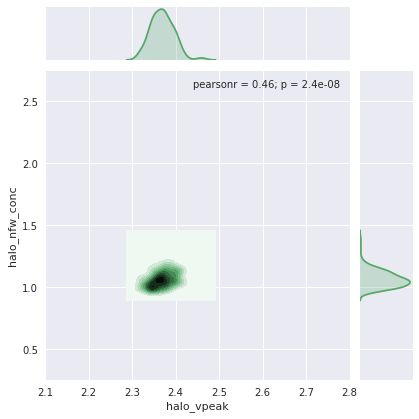

In [33]:
tabulated_hod_jointplot((sham_cen_hod, sham_sat_hod), (HSAssembiasTabulatedCens, HSAssembiasTabulatedSats),
                            'HSAB', bin_no = bin_no,
                            ab_dict = {'mean_occupation_centrals_assembias_param1':1.0,
                                       'mean_occupation_satellites_assembias_param1':-1.0})

---

In [34]:
from pearce.mocks.customHODModels import Tabulated2DCens, Tabulated2DSats
from pearce.mocks.assembias_models.table_utils import compute_prim_haloprop_bins

In [35]:
from collections import Counter
def compute_occupations(halo_catalog, galaxy_catalog):

    cens_occ = np.zeros((np.sum(halo_catalog['halo_upid'] == -1),))
    sats_occ = np.zeros_like(cens_occ)
    
    detected_central_ids = set(galaxy_catalog[galaxy_catalog['halo_upid']==-1]['halo_id'])
    detected_satellite_upids = Counter(galaxy_catalog[galaxy_catalog['halo_upid']!=-1]['halo_upid'])

    for idx, row  in enumerate(halo_catalog[halo_catalog['halo_upid'] == -1]):
        cens_occ[idx] = 1.0 if row['halo_id'] in detected_central_ids else 0.0
        sats_occ[idx]+= detected_satellite_upids[row['halo_id']]

    return cens_occ, sats_occ

In [36]:
cens_occ, sats_occ = compute_occupations(cat2.halocat.halo_table, galcat)

In [39]:
def calc_2dhod(mass_bins,conc_bins,sec_haloprop_key, halocat, cens_occ, sats_occ):
    
    host_halos = halocat['halo_upid'] == -1
    
    halo_mass = halocat['halo_mvir']
    halo_sec =halocat[sec_haloprop_key]
    
    host_halo_mass = halo_mass[host_halos]
    host_halo_sec = halo_sec[host_halos]

    #host_mass_bin_idxs = compute_prim_haloprop_bins(prim_haloprop_bin_boundaries=mass_bins, prim_haloprop = host_halo_mass)
    mass_bin_idxs = compute_prim_haloprop_bins(prim_haloprop_bin_boundaries=mass_bins, prim_haloprop = halo_mass)
    host_mass_bin_idxs = mass_bin_idxs[host_halos]
    conditional_sec_percentiles = compute_conditional_percentiles(prim_haloprop  = halo_mass,\
                                                                  sec_haloprop = halo_sec,\
                                                                  prim_haloprop_bin_boundaries = mass_bins)
    
    #host_conditional_sec_percentiles = np.zeros((len(galcat),))
    #host_halocat_idxs = np.in1d(halocat['halo_id'], galcat['halo_hostid'], assume_unique=True)
    #print len(galcat), np.sum(host_halocat_idxs)
    #host_sort_idxs = np.argsort(galcat['halo_hostid'])
    #sort_idxs = np.argsort(halocat[host_halocat_idxs]['halo_id'])
    #host_conditional_sec_percentiles[host_sort_idxs] = conditional_sec_percentiles[host_halocat_idxs][sort_idxs]

    host_conditional_sec_percentiles = conditional_sec_percentiles[host_halos]

    mean_ncen = np.zeros((len(mass_bins)-1, len(conc_bins)-1))
    mean_nsat = np.zeros((len(mass_bins)-1, len(conc_bins)-1))
    
    mass_bin_nos = range(len(mass_bins)-1)#,1)
    for bin_no in mass_bin_nos:
        bin_center = np.mean(mass_bins[bin_no-1:bin_no+1])
        indices_of_host_mb = np.where(host_mass_bin_idxs == bin_no)[0]
        indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]

        if len(indices_of_mb) == 0 or len(indices_of_host_mb) == 0:
            continue
            
        #print np.sum(~np.isfinite(halo_sec[host_conditional_sec_percentiles<0.9])),
        #print np.sum(~np.isfinite(halo_sec[host_conditional_sec_percentiles>0.9]))

            
        #print len(indices_of_mb), len(indices_of_host_mb)
        (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(host_conditional_sec_percentiles[indices_of_host_mb],\
                                                                      cens_occ[indices_of_host_mb],bins=conc_bins, statistic='sum'), \
                                   binned_statistic(host_conditional_sec_percentiles[indices_of_host_mb],\
                                                                      sats_occ[indices_of_host_mb],bins=conc_bins,statistic='sum')

        binned_halos, _, _ = binned_statistic(conditional_sec_percentiles[indices_of_mb],
                                                 None, bins=conc_bins, statistic='count')
        
        mean_ncen[bin_no-1,:] = binned_cens/binned_halos
        mean_nsat[bin_no-1,:] = binned_sats/binned_halos
        
        # NOTE these don't do anytng cuz there are no halos in these bins!
        if np.any(np.isnan(mean_ncen[bin_no-1,:])):
            mean_ncen[bin_no-1,np.isnan(mean_ncen[bin_no-1,:])] = 0.0#np.sum(binne)
            
        if np.any(np.isnan(mean_nsat[bin_no-1,:])):
            mean_nsat[bin_no-1,np.isnan(mean_nsat[bin_no-1,:] )] = 0.0#sat_hod[bin_no-1]
            
    return mean_ncen, mean_nsat

In [40]:
#TODO what is up with the last bin? 
conc_bins = np.linspace(0,1,41)
sham_cen_2dhod, sham_sat_2dhod = calc_2dhod(mass_bins, conc_bins, 'halo_nfw_conc', cat2.halocat.halo_table,
                                        cens_occ, sats_occ)

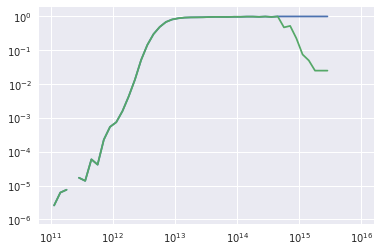

In [42]:
plt.plot(mass_bin_centers, sham_cen_hod)
plt.plot(mass_bin_centers, np.nanmean(sham_cen_2dhod, axis =1))
#plt.plot(mass_bin_centers, np.nanmean(sham_cen_hod_v2, axis =1))

plt.loglog();

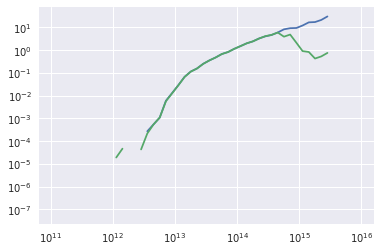

In [43]:
plt.plot(mass_bin_centers, sham_sat_hod)
plt.plot(mass_bin_centers, np.nanmean(sham_sat_2dhod, axis =1))
plt.loglog();

In [44]:
cat2.load_model(1.0, HOD=(Tabulated2DCens, Tabulated2DSats), hod_kwargs = {'prim_haloprop_bins': mass_bins,
                                                               'sec_haloprop_perc_bins': conc_bins,
                                                                'sec_haloprop_key': 'halo_nfw_conc',
                                                               'cen_hod_vals':sham_cen_2dhod,
                                                               'sat_hod_vals':sham_sat_2dhod})

In [45]:
cat2.populate()

In [46]:
xi_2d = cat2.calc_xi(rbins)

[]

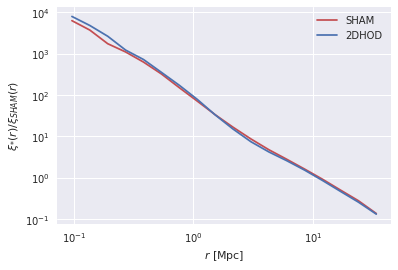

In [47]:
plt.plot(rbc, sham_xi, label = 'SHAM', color = model_color_map['SHAM'][0])
plt.plot(rbc, xi_2d, label = '2DHOD', color = model_color_map['HOD'][0])

#plt.plot(rbc, hod_xi)
plt.legend(loc = 'best')
#plt.ylim([0.9, 1.05])
plt.xlabel(r"$r$ [Mpc]")
plt.ylabel(r"$\xi_{*}(r)/\xi_{SHAM}(r)$")
plt.loglog()

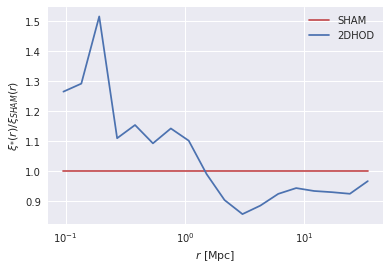

In [48]:
plt.plot(rbc, sham_xi/sham_xi, label = 'SHAM', color = model_color_map['SHAM'][0])
plt.plot(rbc, xi_2d/sham_xi, label = '2DHOD', color = model_color_map['HOD'][0])

#plt.plot(rbc, hod_xi)
plt.legend(loc = 'best')
#plt.ylim([0.9, 1.05])
plt.xlabel(r"$r$ [Mpc]")
plt.ylabel(r"$\xi_{*}(r)/\xi_{SHAM}(r)$")
plt.xscale('log')

In [49]:
conc_bins = np.linspace(0,1,21)
sham_cen_2dhod, sham_sat_2dhod = calc_2dhod(mass_bins, conc_bins, 'halo_vpeak', cat2.halocat.halo_table,
                                        cens_occ, sats_occ)

In [50]:
cat2.load_model(1.0, HOD=(Tabulated2DCens, Tabulated2DSats), hod_kwargs = {'prim_haloprop_bins': mass_bins,
                                                               'sec_haloprop_perc_bins': conc_bins,
                                                                'sec_haloprop_key': 'halo_nfw_conc',
                                                               'cen_hod_vals':sham_cen_2dhod,
                                                               'sat_hod_vals':sham_sat_2dhod})

In [51]:
cat2.populate()

In [52]:
xi_2d_vpeak = cat2.calc_xi(rbins)

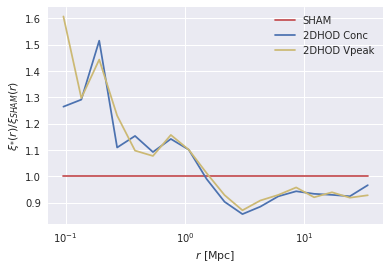

In [53]:
plt.plot(rbc, sham_xi/sham_xi, label = 'SHAM', color = model_color_map['SHAM'][0])
plt.plot(rbc, xi_2d/sham_xi, label = '2DHOD Conc', color = model_color_map['HOD'][0])
plt.plot(rbc, xi_2d_vpeak/sham_xi, label = '2DHOD Vpeak', color = model_color_map['CorrAB'][0])

#plt.plot(rbc, hod_xi)
plt.legend(loc = 'best')
#plt.ylim([0.9, 1.05])
plt.xlabel(r"$r$ [Mpc]")
plt.ylabel(r"$\xi_{*}(r)/\xi_{SHAM}(r)$")
plt.xscale('log')

---

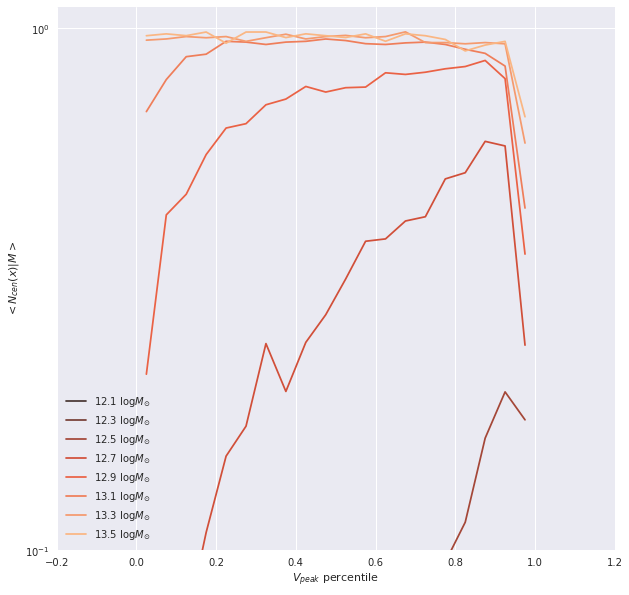

In [54]:
fig = plt.figure(figsize = (10,10))
cbc = (conc_bins[1:]+conc_bins[:-1])/2.0
mass_slice = np.logical_and(10**12.0 < mass_bin_centers, mass_bin_centers < 10**13.5)
colors = sns.color_palette(model_color_map['SHAM'][1], len(mass_bin_centers[mass_slice]))
for idx, (row,c,m) in enumerate(zip(sham_cen_2dhod[mass_slice], colors, mass_bin_centers[mass_slice])):
    if idx%2!=0:
        continue
    plt.plot(cbc, row, color = c, label = r'%.1f $\log M_{\odot}$'%np.log10(m))
    
#plt.ylim(-0.2,1.2)
plt.xlim(-0.2, 1.2);
plt.xlabel('%s percentile'%r"$V_{peak}$")
plt.ylabel(r'$<N_{cen}(x)|M>$')
plt.yscale('log')
plt.ylim([0.1, 1.1])
plt.legend(loc='best')

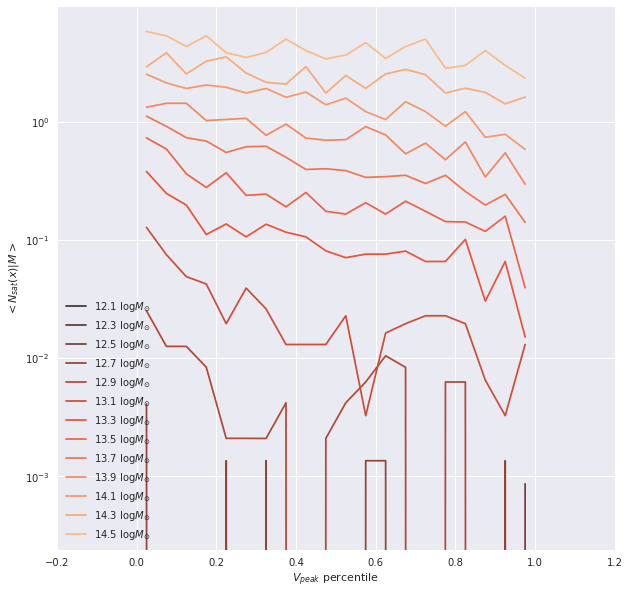

In [55]:
fig = plt.figure(figsize = (10,10))
cbc = (conc_bins[1:]+conc_bins[:-1])/2.0
mass_slice = np.logical_and(10**12.0 < mass_bin_centers, mass_bin_centers < 10**14.5)
colors = sns.color_palette(model_color_map['SHAM'][1], len(mass_bin_centers[mass_slice]))
for idx, (row,c,m) in enumerate(zip(sham_sat_2dhod[mass_slice], colors, mass_bin_centers[mass_slice])):
    if idx%2!=0:
        continue
    plt.plot(cbc, row, color = c, label = r'%.1f $\log M_{\odot}$'%np.log10(m))
    
#plt.ylim(-0.2,1.2)
plt.xlim(-0.2, 1.2);
plt.xlabel('%s percentile'%r"$V_{peak}$")
plt.ylabel(r'$<N_{sat}(x)|M>$')
plt.yscale('log')
#plt.ylim([0.1, 1.1])
plt.legend(loc='best')

In [80]:
cat2.load_model(1.0, HOD='corrZheng07', hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
                                                               'sec_haloprop_key': 'halo_vpeak',#%(mag_type),
                                                               'cen_hod_vals':sham_cen_hod,
                                                               'sat_hod_vals':sham_sat_hod} )
ab_dict = {'mean_occupation_centrals_assembias_corr1':1.0,
                                       'mean_occupation_satellites_assembias_corr1':-1.0}
cat2.model.param_dict.update(ab_dict)
cat2.populate(min_ptcl=100)


In [81]:
cens_occ_hod, sats_occ_hod = compute_occupations(cat2.halocat.halo_table, cat2.model.mock.galaxy_table)

In [82]:
hod_cen_2dhod, hod_sat_2dhod = calc_2dhod(mass_bins, conc_bins, 'halo_vpeak', cat2.halocat.halo_table,
                                        cens_occ_hod, sats_occ_hod)

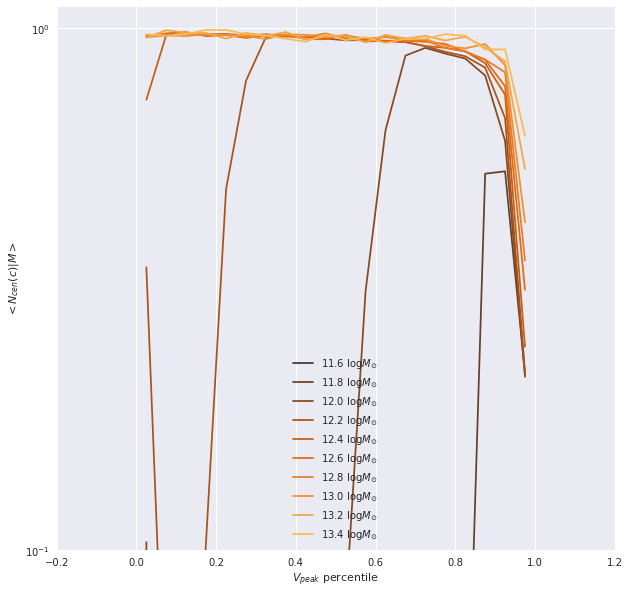

In [83]:
fig = plt.figure(figsize = (10,10))
cbc = (conc_bins[1:]+conc_bins[:-1])/2.0
mass_slice = np.logical_and(10**11.5 < mass_bin_centers, mass_bin_centers < 10**13.5)
colors = sns.color_palette(model_color_map['CorrAB'][1], len(mass_bin_centers[mass_slice]))
for idx, (row,c,m) in enumerate(zip(hod_cen_2dhod[mass_slice], colors, mass_bin_centers[mass_slice])):
    if idx%2!=0:
        continue
    plt.plot(cbc, row, color = c, label = r'%.1f $\log M_{\odot}$'%np.log10(m))
    
plt.ylim(0.1,1.1)
plt.xlim(-0.2, 1.2);
plt.xlabel('%s percentile'%r"$V_{peak}$")
plt.ylabel(r'$<N_{cen}(c)|M>$')
plt.yscale('log')
plt.legend(loc='best')

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/ticker.py:2039: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


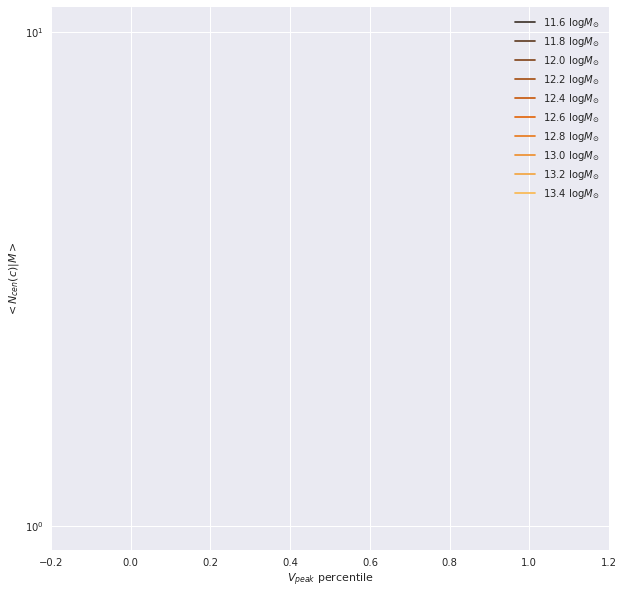

In [84]:
fig = plt.figure(figsize = (10,10))
cbc = (conc_bins[1:]+conc_bins[:-1])/2.0
mass_slice = np.logical_and(10**11.5 < mass_bin_centers, mass_bin_centers < 10**13.5)
colors = sns.color_palette(model_color_map['CorrAB'][1], len(mass_bin_centers[mass_slice]))
for idx, (row,c,m) in enumerate(zip(hod_sat_2dhod[mass_slice], colors, mass_bin_centers[mass_slice])):
    if idx%2!=0:
        continue
    plt.plot(cbc, row, color = c, label = r'%.1f $\log M_{\odot}$'%np.log10(m))
    
#plt.ylim(0.1,1.1)
plt.xlim(-0.2, 1.2);
plt.xlabel('%s percentile'%r"$V_{peak}$")
plt.ylabel(r'$<N_{cen}(c)|M>$')
plt.yscale('log')
plt.legend(loc='best')

In [75]:
cat2.load_model(1.0, HOD='hsabZheng07', hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
                                                               'sec_haloprop_key': 'halo_vpeak',
                                                               'cen_hod_vals':sham_cen_hod,
                                                               'sat_hod_vals':sham_sat_hod} )
ab_dict = {'mean_occupation_centrals_assembias_param1':1.0,
                                       'mean_occupation_satellites_assembias_param1':-1.0}
cat2.model.param_dict.update(ab_dict)
cat2.populate(min_ptcl=100)


In [76]:
cens_occ_hod, sats_occ_hod = compute_occupations(cat2.halocat.halo_table, cat2.model.mock.galaxy_table)

In [77]:
hod_cen_2dhod, hod_sat_2dhod = calc_2dhod(mass_bins, conc_bins, 'halo_vpeak', cat2.halocat.halo_table,
                                        cens_occ_hod, sats_occ_hod)

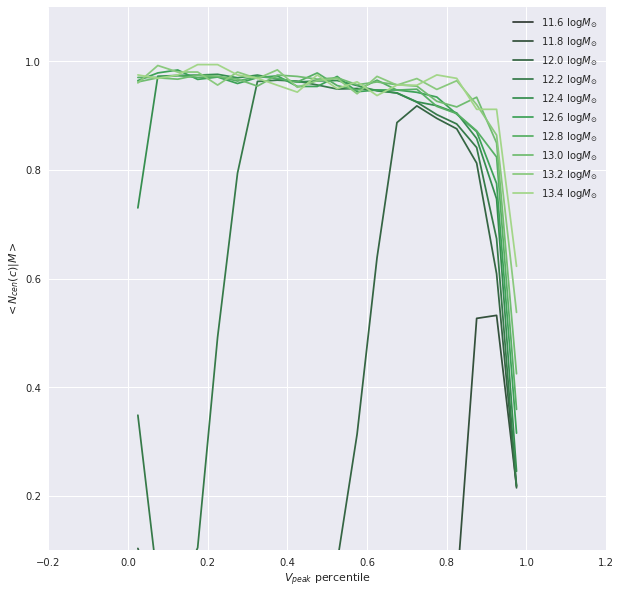

In [85]:
fig = plt.figure(figsize = (10,10))
cbc = (conc_bins[1:]+conc_bins[:-1])/2.0
mass_slice = np.logical_and(10**11.5 < mass_bin_centers, mass_bin_centers < 10**13.5)
colors = sns.color_palette(model_color_map['HSAB'][1], len(mass_bin_centers[mass_slice]))
for idx, (row,c,m) in enumerate(zip(hod_cen_2dhod[mass_slice], colors, mass_bin_centers[mass_slice])):
    if idx%2!=0:
        continue
    plt.plot(cbc, row, color = c, label = r'%.1f $\log M_{\odot}$'%np.log10(m))
    
plt.ylim(0.1,1.1)
plt.xlim(-0.2, 1.2);
plt.xlabel('%s percentile'%r"$V_{peak}$")
plt.ylabel(r'$<N_{cen}(c)|M>$')
#plt.yscale('log')
plt.legend(loc='best')